# Create a visualisation of the cassette spool

In [191]:
import math
from PIL import Image, ImageDraw,ImageColor

def createCircle(r,x,y):
    t = 0
    positions = []
    # 1 pixel for every unit in the circumference
    STEP_SIZE = (1/r)
    while t < 2 * math.pi:
        positions.append((r * math.cos(t) + x, r * math.sin(t) + y))
        t += STEP_SIZE
    return positions

In [276]:
def getByteColor(b):
    # Short
    if b in range(0x24,0x37):
        return ImageColor.getrgb("lightgray")
    # Medium
    if b in range(0x37,0x4a):
        return ImageColor.getrgb("blue")
    # Long
    return ImageColor.getrgb("pink")

In [280]:
def drawSpoolCore(img):
    draw = ImageDraw.Draw(img)
    # Draw the core of the tape spool
    draw.ellipse((ox-80, ox-80, oy+80, oy+80), outline="lightgrey",width=20)
    # Draw the teeth on the tape spool
    draw.line((ox + 40, oy, ox+70, oy), fill = "lightgrey", width = 20)
    draw.line((ox - 40, oy, ox-70, oy), fill = "lightgrey", width = 20)
    draw.line((ox +20, oy+35, ox+45, oy+65), fill = "lightgrey", width = 20)
    draw.line((ox -20, oy-35, ox-45, oy-65), fill = "lightgrey", width = 20)
    draw.line((ox -20, oy+35, ox-45, oy+65), fill = "lightgrey", width = 20)
    draw.line((ox +20, oy-35, ox+45, oy-65), fill = "lightgrey", width = 20)
    return img

Create an image showing each short/medium/long pulse as a pixel on the tape spool

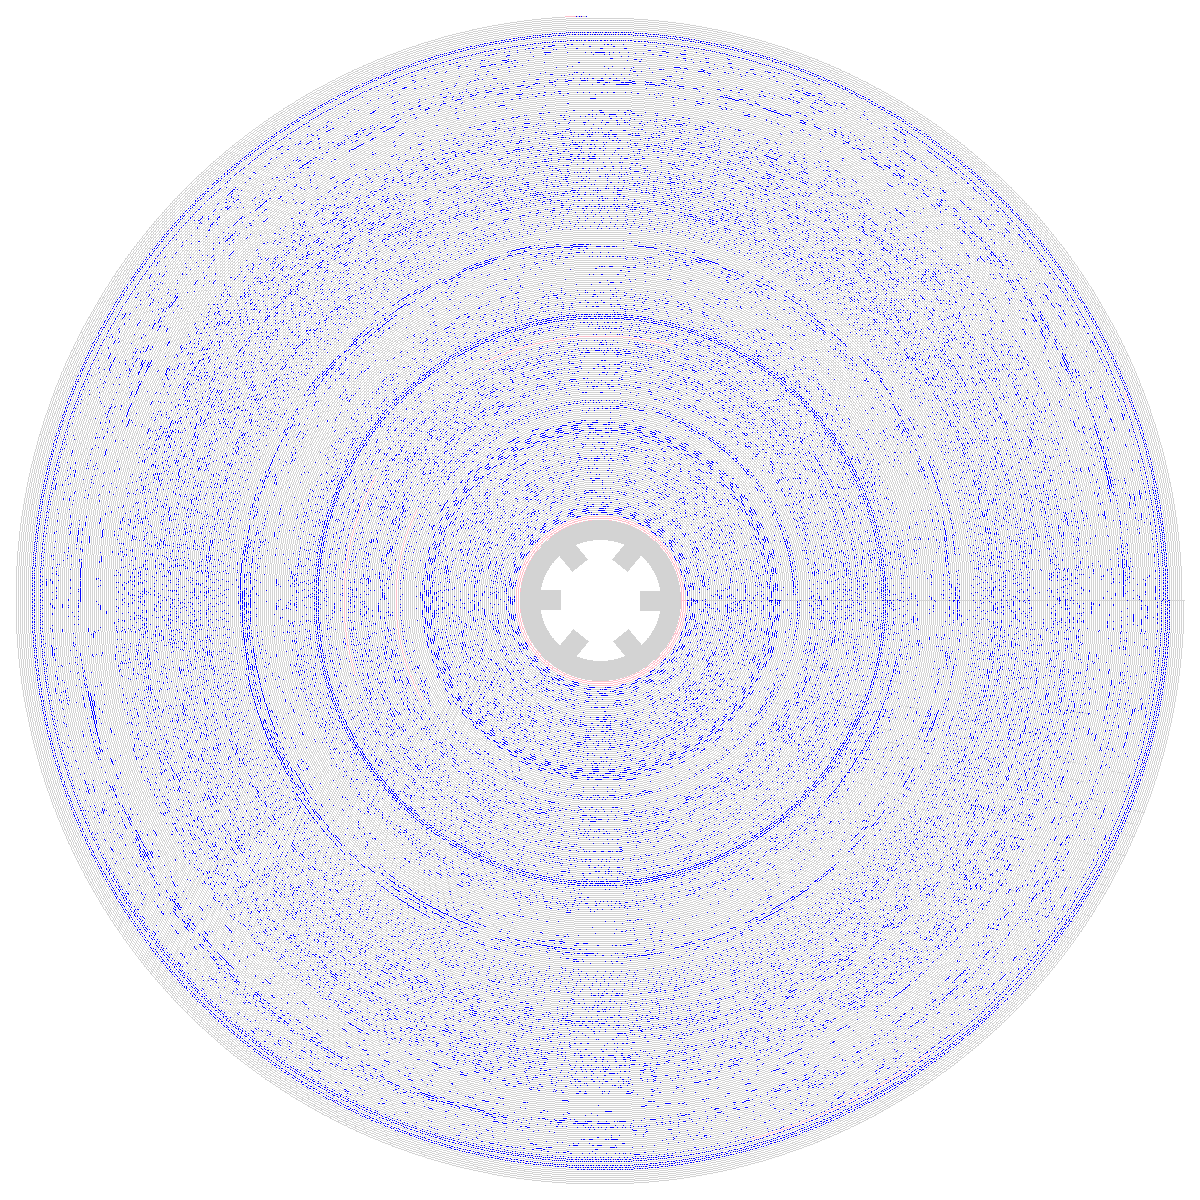

In [281]:
filename_in = "iridis-alpha.tap"
data = bytearray(reversed(bytearray(open(filename_in, 'rb').read())))

h = 1200
w = h
ox = int(h/2) # ox/oy is the center of the circle
oy = int(h/2)

img = Image.new('RGB', (h, w), color = 'white')
pixels = img.load() # create the pixel map

pos = 0
for r in range(80, 590, 2):
    positions = createCircle(r,ox,oy)
    for x,y in positions:
        if pos > len(data) - 1:
            break
        pixels[x,y] = getByteColor(data[pos])
        pos += 1

img = drawSpoolCore(img)

img.save("../src/archaeo/spool.png")
img

Create an image showing the different data sections on the spool

In [307]:
colors = {
 'C64 ROM-TAPE DATA': "red",
 'C64 ROM-TAPE HEADER': "red",
 'Header': "black",
 'MEGA-SAVE T2': "lightgreen",
 'Pause': "gray",
 'Pilot bytes': "darkgray",
 'Trailer Bytes': "lightgray",
}

tap_mapping = [(0, "Header")]
input_file = open("iridis-alpha.tap_report.txt", 'r')
for l in input_file.readlines():
    if "File Type" in l:
        file_type = l.split(":")[1].strip()
        continue
    if "Location" in l:
        locs = l.split(":")[1].strip()
        loc_list = [loc.strip().replace("$","") for loc in locs.split("->")]
        loc_list = [int(l,16) for l in loc_list]
        if not loc_list[1]:
            tap_mapping += [(loc_list[0], "Pause")]
            continue
        tap_mapping += [(loc_list[0], "Pilot bytes")]
        tap_mapping += [(loc_list[1], file_type)]
        tap_mapping += [(loc_list[2], "Trailer Bytes")]
tap_mapping += [(0x80a6d, "Pause")]

# Create a range mapping
tap_range_mapping = []
e = 0
for i, (e,n) in enumerate(tap_mapping):
    if e:
        tap_range_mapping += [((pe,e),pn,pc)]
    pe = e
    pn = n
    pc = colors[n]
tap_range_mapping += [((pe,e),pn,pc)]
    


In [294]:
def getColorForPos(pos):
    for (s,e), section, color in tap_range_mapping:
        if pos in range(s,e):
            return ImageColor.getrgb(color)
    return ImageColor.getrgb("orange")

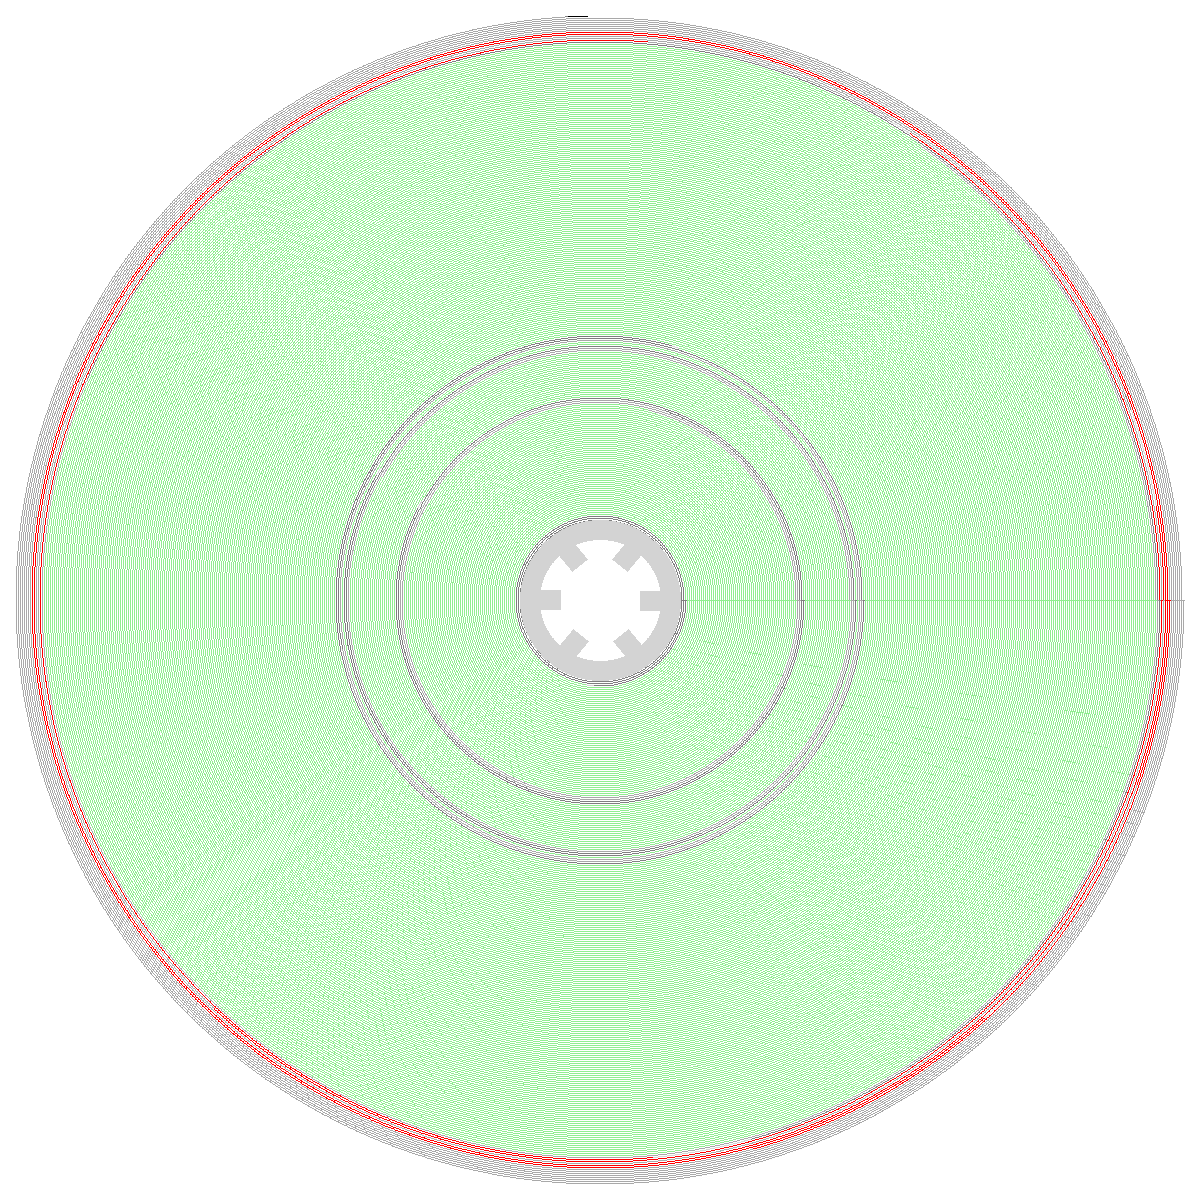

In [308]:
filename_in = "iridis-alpha.tap"
data_len = len(bytearray(open(filename_in, 'rb').read()))

h = 1200
w = h
ox = int(h/2) # ox/oy is the center of the circle
oy = int(h/2)

img = Image.new('RGB', (h, w), color = 'white')
pixels = img.load() # create the pixel map

pos = data_len
for r in range(80, 590, 2):
    positions = createCircle(r,ox,oy)
    for x,y in positions:
        if pos < 0:
            break
        pixels[x,y] = getColorForPos(pos)
        pos -= 1

img = drawSpoolCore(img)
img.save("../src/archaeo/spool-sections.png")
img